In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss)
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    original_loss = focal_loss(student_outputs[:,0,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            #loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0514_Focal_Loss_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 7s 629ms/step - loss: 0.1010
Average validation loss: 0.1278981864452362
4/4 [==============================] - 7s 644ms/step - loss: 0.1010 - val_loss: 0.1279
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_0\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 9s 678ms/step - loss: 0.0782 - val_loss: 0.1279
Average validation loss: 0.11225194483995438
4/4 [==============================] - 10s 693ms/step - loss: 0.0782 - val_loss: 0.1201
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_0\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 13s 752ms/step - loss: 0.0598 - val_loss: 0.1201
Average validation loss: 0.1409156322479248
4/4 [==============================] - 13s 771ms/step - loss: 0.0598 - val_loss: 0.1270
Epoch 4/10
4/4 [==============================] -

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 733ms/step - loss: 0.0033
Average validation loss: 0.45559291541576385
8/8 [==============================] - 6s 745ms/step - loss: 0.0033 - val_loss: 0.4556
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_0\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 12s 717ms/step - loss: 0.0033 - val_loss: 0.4556
Average validation loss: 0.7555733323097229
8/8 [==============================] - 12s 729ms/step - loss: 0.0033 - val_loss: 0.6056
Epoch 3/10
8/8 [==============================] - 18s 734ms/step - loss: 0.0031 - val_loss: 0.6056
Average validation loss: 0.32632875442504883
8/8 [==============================] - 18s 746ms/step - loss: 0.0031 - val_loss: 0.5125
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_0\segformer_data_size_10.pth'.
Epoch 4/10
8/8 [=============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 758ms/step - loss: 0.0037
Average validation loss: 0.17923076947530112
12/12 [==============================] - 9s 771ms/step - loss: 0.0037 - val_loss: 0.1792
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_0\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 18s 717ms/step - loss: 0.0039 - val_loss: 0.1792
Average validation loss: 0.20472495257854462
12/12 [==============================] - 18s 728ms/step - loss: 0.0039 - val_loss: 0.1920
Epoch 3/10
12/12 [==============================] - 27s 768ms/step - loss: 0.0039 - val_loss: 0.1920
Average validation loss: 0.2872594992319743
12/12 [==============================] - 27s 780ms/step - loss: 0.0039 - val_loss: 0.2237
Epoch 4/10
12/12 [==============================] - 36s 708ms/step - loss: 0.0039 - val_loss: 0.2237
Average validation loss: 0.15926619867483774
12/12 [==========================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 737ms/step - loss: 0.0043
Average validation loss: 0.24943945184350014
16/16 [==============================] - 12s 750ms/step - loss: 0.0043 - val_loss: 0.2494
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_0\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 24s 714ms/step - loss: 0.0040 - val_loss: 0.2494
Average validation loss: 0.36949608474969864
16/16 [==============================] - 24s 727ms/step - loss: 0.0040 - val_loss: 0.3095
Epoch 3/10
16/16 [==============================] - 35s 721ms/step - loss: 0.0038 - val_loss: 0.3095
Average validation loss: 0.23850082606077194
16/16 [==============================] - 36s 733ms/step - loss: 0.0038 - val_loss: 0.2858
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_0\segformer_data_size_20.pth'.
Epoch 4/10
16/16 [============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 716ms/step - loss: 0.0021
Average validation loss: 0.2904343783855438
20/20 [==============================] - 15s 729ms/step - loss: 0.0021 - val_loss: 0.2904
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_0\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 718ms/step - loss: 0.0021 - val_loss: 0.2904
Average validation loss: 0.3726402521133423
20/20 [==============================] - 29s 730ms/step - loss: 0.0021 - val_loss: 0.3315
Epoch 3/10
20/20 [==============================] - 44s 724ms/step - loss: 0.0021 - val_loss: 0.3315
Average validation loss: 0.2524846255779266
20/20 [==============================] - 44s 735ms/step - loss: 0.0021 - val_loss: 0.3052
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_0\segformer_data_size_25.pth'.
Epoch 4/10
20/20 [===============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 727ms/step - loss: 0.0020
Average validation loss: 0.19680767009655634
24/24 [==============================] - 18s 738ms/step - loss: 0.0020 - val_loss: 0.1968
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_0\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 733ms/step - loss: 0.0020 - val_loss: 0.1968
Average validation loss: 0.239216148853302
24/24 [==============================] - 36s 746ms/step - loss: 0.0020 - val_loss: 0.2180
Epoch 3/10
24/24 [==============================] - 53s 711ms/step - loss: 0.0020 - val_loss: 0.2180
Average validation loss: 0.26288728912671405
24/24 [==============================] - 53s 724ms/step - loss: 0.0020 - val_loss: 0.2330
Epoch 4/10
24/24 [==============================] - 70s 716ms/step - loss: 0.0020 - val_loss: 0.2330
Average validation loss: 0.35719292362531024
24/24 [=========================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 29s 713ms/step - loss: 0.0025
Average validation loss: 0.23702175170183182
40/40 [==============================] - 29s 725ms/step - loss: 0.0025 - val_loss: 0.2370
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_0\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 58s 727ms/step - loss: 0.0025 - val_loss: 0.2370
Average validation loss: 0.23930933326482773
40/40 [==============================] - 59s 739ms/step - loss: 0.0025 - val_loss: 0.2382
Epoch 3/10
40/40 [==============================] - 87s 711ms/step - loss: 0.0024 - val_loss: 0.2382
Average validation loss: 0.23013847172260285
40/40 [==============================] - 88s 723ms/step - loss: 0.0024 - val_loss: 0.2355
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_0\segformer_data_size_50.pth'.
Epoch 4/10
40/40 [============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 34s 717ms/step - loss: 0.0038
Average validation loss: 0.21474613000949225
48/48 [==============================] - 35s 729ms/step - loss: 0.0038 - val_loss: 0.2147
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_0\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 70s 721ms/step - loss: 0.0031 - val_loss: 0.2147
Average validation loss: 0.24130225802461305
48/48 [==============================] - 70s 733ms/step - loss: 0.0031 - val_loss: 0.2280
Epoch 3/10
48/48 [==============================] - 105s 717ms/step - loss: 0.0027 - val_loss: 0.2280
Average validation loss: 0.1998550295829773
48/48 [==============================] - 105s 729ms/step - loss: 0.0027 - val_loss: 0.2186
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_0\segformer_data_size_60.pth'.
Epoch 4/10
48/48 [===========

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 40s 717ms/step - loss: 0.0019
Average validation loss: 0.261001569884164
56/56 [==============================] - 41s 729ms/step - loss: 0.0019 - val_loss: 0.2610
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_0\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 81s 716ms/step - loss: 0.0016 - val_loss: 0.2610
Average validation loss: 0.2164187537772315
56/56 [==============================] - 82s 727ms/step - loss: 0.0016 - val_loss: 0.2387
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_0\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 122s 724ms/step - loss: 0.0014 - val_loss: 0.2387
Average validation loss: 0.1561082186443465
56/56 [==============================] - 123s 737ms/step - loss: 0.0014 - val_loss: 0.2112
Saved model weights to 'c:\Users

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 46s 723ms/step - loss: 0.0018
Average validation loss: 0.2008368158712983
64/64 [==============================] - 47s 735ms/step - loss: 0.0018 - val_loss: 0.2008
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_0\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 93s 723ms/step - loss: 0.0014 - val_loss: 0.2008
Average validation loss: 0.17321092914789915
64/64 [==============================] - 94s 734ms/step - loss: 0.0014 - val_loss: 0.1870
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_0\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 140s 717ms/step - loss: 0.0013 - val_loss: 0.1870
Average validation loss: 0.21736797504127026
64/64 [==============================] - 141s 728ms/step - loss: 0.0013 - val_loss: 0.1971
Epoch 4/10
64/64 [===========

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 52s 718ms/step - loss: 0.0014
Average validation loss: 0.23821265498797098
72/72 [==============================] - 52s 729ms/step - loss: 0.0014 - val_loss: 0.2382
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_0\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 105s 725ms/step - loss: 0.0011 - val_loss: 0.2382
Average validation loss: 0.2143341741628117
72/72 [==============================] - 106s 736ms/step - loss: 0.0011 - val_loss: 0.2263
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_0\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 158s 731ms/step - loss: 9.3497e-04 - val_loss: 0.2263
Average validation loss: 0.22481492161750793
72/72 [==============================] - 159s 743ms/step - loss: 9.3497e-04 - val_loss: 0.2258
Epoch 4/10
72/72 [=

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 57s 718ms/step - loss: 0.0014
Average validation loss: 0.22976637184619902
80/80 [==============================] - 58s 729ms/step - loss: 0.0014 - val_loss: 0.2298
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_0\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 117s 726ms/step - loss: 0.0012 - val_loss: 0.2298
Average validation loss: 0.19758733734488487
80/80 [==============================] - 117s 737ms/step - loss: 0.0012 - val_loss: 0.2137
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_0\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 175s 725ms/step - loss: 0.0011 - val_loss: 0.2137
Average validation loss: 0.22567692250013352
80/80 [==============================] - 176s 737ms/step - loss: 0.0011 - val_loss: 0.2177
Epoch 4/10
80/80 [======

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 69s 721ms/step - loss: 0.0018
Average validation loss: 0.20664227567613125
96/96 [==============================] - 70s 732ms/step - loss: 0.0018 - val_loss: 0.2066
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_0\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 140s 722ms/step - loss: 0.0014 - val_loss: 0.2066
Average validation loss: 0.22270291236539683
96/96 [==============================] - 141s 733ms/step - loss: 0.0014 - val_loss: 0.2147
Epoch 3/10
96/96 [==============================] - 210s 716ms/step - loss: 0.0012 - val_loss: 0.2147
Average validation loss: 0.20377218847473463
96/96 [==============================] - 211s 728ms/step - loss: 0.0012 - val_loss: 0.2110
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_0\segformer_data_size_120.pth'.
Epoch 4/10
96/96 [======

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 86s 716ms/step - loss: 0.0016
Average validation loss: 0.2446167652805646
120/120 [==============================] - 87s 728ms/step - loss: 0.0016 - val_loss: 0.2446
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_0\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 173s 712ms/step - loss: 0.0013 - val_loss: 0.2446
Average validation loss: 0.19583871910969416
120/120 [==============================] - 174s 723ms/step - loss: 0.0013 - val_loss: 0.2202
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_0\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 259s 707ms/step - loss: 0.0011 - val_loss: 0.2202
Average validation loss: 0.2204113110899925
120/120 [==============================] - 261s 719ms/step - loss: 0.0011 - val_loss: 0.2203
Epoch 4/10
120

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 103s 713ms/step - loss: 0.0012
Average validation loss: 0.2046383942166964
144/144 [==============================] - 104s 725ms/step - loss: 0.0012 - val_loss: 0.2046
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_0\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 207s 712ms/step - loss: 9.7004e-04 - val_loss: 0.2046
Average validation loss: 0.20545126125216484
144/144 [==============================] - 209s 723ms/step - loss: 9.7004e-04 - val_loss: 0.2050
Epoch 3/10
144/144 [==============================] - 312s 715ms/step - loss: 8.7720e-04 - val_loss: 0.2050
Average validation loss: 0.21089654457237986
144/144 [==============================] - 313s 727ms/step - loss: 8.7720e-04 - val_loss: 0.2070
Epoch 4/10
144/144 [==============================] - 416s 716ms/step - loss: 7.9540e-04 - val_loss: 0.2070
Average validation loss: 0.2040846

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 115s 716ms/step - loss: 0.0012
Average validation loss: 0.22178762294352056
160/160 [==============================] - 116s 727ms/step - loss: 0.0012 - val_loss: 0.2218
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_0\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 231s 713ms/step - loss: 9.7491e-04 - val_loss: 0.2218
Average validation loss: 0.2361618299037218
160/160 [==============================] - 232s 725ms/step - loss: 9.7491e-04 - val_loss: 0.2290
Epoch 3/10
160/160 [==============================] - 346s 712ms/step - loss: 8.5300e-04 - val_loss: 0.2290
Average validation loss: 0.2508961331099272
160/160 [==============================] - 348s 724ms/step - loss: 8.5300e-04 - val_loss: 0.2363
Epoch 4/10
160/160 [==============================] - 463s 718ms/step - loss: 7.6579e-04 - val_loss: 0.2363
Average validation loss: 0.16872505

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 144s 718ms/step - loss: 0.0015
Average validation loss: 0.18694997131824492
200/200 [==============================] - 146s 729ms/step - loss: 0.0015 - val_loss: 0.1869
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_0\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 289s 715ms/step - loss: 0.0011 - val_loss: 0.1869
Average validation loss: 0.2294202095270157
200/200 [==============================] - 291s 726ms/step - loss: 0.0011 - val_loss: 0.2082
Epoch 3/10
200/200 [==============================] - 434s 714ms/step - loss: 9.7305e-04 - val_loss: 0.2082
Average validation loss: 0.20720753192901611
200/200 [==============================] - 436s 725ms/step - loss: 9.7305e-04 - val_loss: 0.2079
Epoch 4/10
200/200 [==============================] - 579s 716ms/step - loss: 8.7763e-04 - val_loss: 0.2079
Average validation loss: 0.203550276160240

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 3:15 - loss: 0.0014

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 173s 719ms/step - loss: 9.8798e-04
Average validation loss: 0.20045930594205857
240/240 [==============================] - 175s 731ms/step - loss: 9.8798e-04 - val_loss: 0.2005
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_0\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 347s 713ms/step - loss: 7.9078e-04 - val_loss: 0.2005
Average validation loss: 0.23379281734426816
240/240 [==============================] - 349s 725ms/step - loss: 7.9078e-04 - val_loss: 0.2171
Epoch 3/10
240/240 [==============================] - 521s 714ms/step - loss: 7.0502e-04 - val_loss: 0.2171
Average validation loss: 0.34830304235219955
240/240 [==============================] - 523s 725ms/step - loss: 7.0502e-04 - val_loss: 0.2609
Epoch 4/10
240/240 [==============================] - 695s 715ms/step - loss: 6.2894e-04 - val_loss: 0.2609
Average validation loss: 

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.3740159372985363, 0.43735015004873273, 0.47280498077472055, 0.3030601754784584, 0.26655593943595884, 0.2528102609018485, 0.23993541529774667, 0.23277229761083923, 0.2161837332376412, 0.22071712834760546, 0.21725932291812367, 0.21943733046948907, 0.20822217531502246, 0.20075444921851157, 0.21957031651503514, 0.20456248884648084, 0.20631296993494036, 0.21834744966526828]
std_val_losses =  [0.24285661620487417, 0.2892373427951802, 0.7647270677532134, 0.1140600932805113, 0.047303099014998046, 0.03075493008904309, 0.026527132761139882, 0.017826319034959577, 0.029426273539036436, 0.017484344940189744, 0.013227513846242793, 0.011617753139263729, 0.01359597034905206, 0.015227058165947608, 0.06529947779812634, 0.02083179707499299, 0.02399558015410121, 0.032434529043532986]


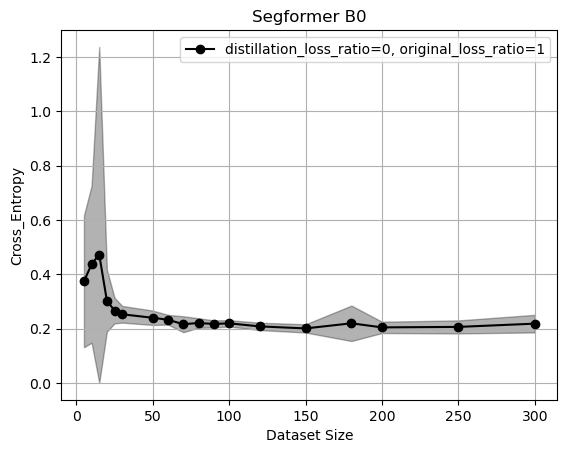

In [2]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()